In [1]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

GETTING DATA

In [2]:
ROOT = './data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
HNSW_SPACE = "hnsw:space"

In [3]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

In [4]:
data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)
files_path

['./data/train/African_crocodile/n01697457_10393.JPEG',
 './data/train/African_crocodile/n01697457_104.JPEG',
 './data/train/African_crocodile/n01697457_1331.JPEG',
 './data/train/African_crocodile/n01697457_14906.JPEG',
 './data/train/African_crocodile/n01697457_18587.JPEG',
 './data/train/African_crocodile/n01697457_260.JPEG',
 './data/train/African_crocodile/n01697457_5586.JPEG',
 './data/train/African_crocodile/n01697457_8136.JPEG',
 './data/train/African_crocodile/n01697457_8331.JPEG',
 './data/train/African_crocodile/n01697457_85.JPEG',
 './data/train/American_egret/n02009912_1358.JPEG',
 './data/train/American_egret/n02009912_13895.JPEG',
 './data/train/American_egret/n02009912_15872.JPEG',
 './data/train/American_egret/n02009912_16896.JPEG',
 './data/train/American_egret/n02009912_26245.JPEG',
 './data/train/American_egret/n02009912_36395.JPEG',
 './data/train/American_egret/n02009912_4403.JPEG',
 './data/train/American_egret/n02009912_5700.JPEG',
 './data/train/American_egret/

In [5]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  # Hide axes
    # Display the plot
    plt.show()

Image embedding

In [6]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

/home/heigetvu/anaconda3/envs/aio-hw2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
img = Image.open('data/train/African_crocodile/n01697457_260.JPEG')
get_single_image_embedding(image=img)

array([ 2.07572337e-02,  1.70053020e-02, -5.46765774e-02,  1.93032920e-02,
        3.82859434e-04,  1.24678276e-02, -1.62833165e-02, -2.15282920e-03,
        5.08179553e-02,  1.31859425e-02, -1.20895226e-02,  7.77475862e-03,
        1.88933201e-02, -3.94190811e-02,  1.14282006e-02,  2.29814723e-02,
       -6.46401793e-02,  2.64379252e-02,  1.48863746e-02,  2.71065999e-03,
       -4.40382957e-02, -6.41890336e-03,  5.66546479e-03, -3.08282450e-02,
       -1.64298937e-02, -3.53648677e-04,  5.32556558e-03, -1.52662275e-02,
       -7.75748584e-03, -2.55334601e-02, -1.27053754e-02,  1.91802382e-02,
        2.37119687e-03,  1.47357443e-02, -2.69961338e-02, -3.94066758e-02,
        1.54179763e-02, -1.43081089e-02, -3.24314386e-02,  1.03276568e-02,
       -1.65552087e-02,  4.11974676e-02, -3.55036855e-02, -1.55740799e-02,
        6.45232154e-03, -3.75169590e-02,  8.52112249e-02,  3.83745395e-02,
        1.91211030e-02,  6.38295058e-03, -9.49577708e-03, -1.40892034e-02,
        3.08665279e-02,  

Chromadb L2 embedding Collection

In [10]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [11]:
# Create a Chroma Client
chroma_client = chromadb.Client()
# Create a collection
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
                                                           metadata={HNSW_SPACE: "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

595it [00:35, 16.99it/s]


In [12]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results # how many results to return
    )
    return results

In [13]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

In [14]:
l2_results

{'ids': [['id_14', 'id_19', 'id_18', 'id_11', 'id_16']],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[None, None, None, None, None]],
 'distances': [[0.40494871139526367,
   0.41227006912231445,
   0.5080229640007019,
   0.5198449492454529,
   0.5294203162193298]]}

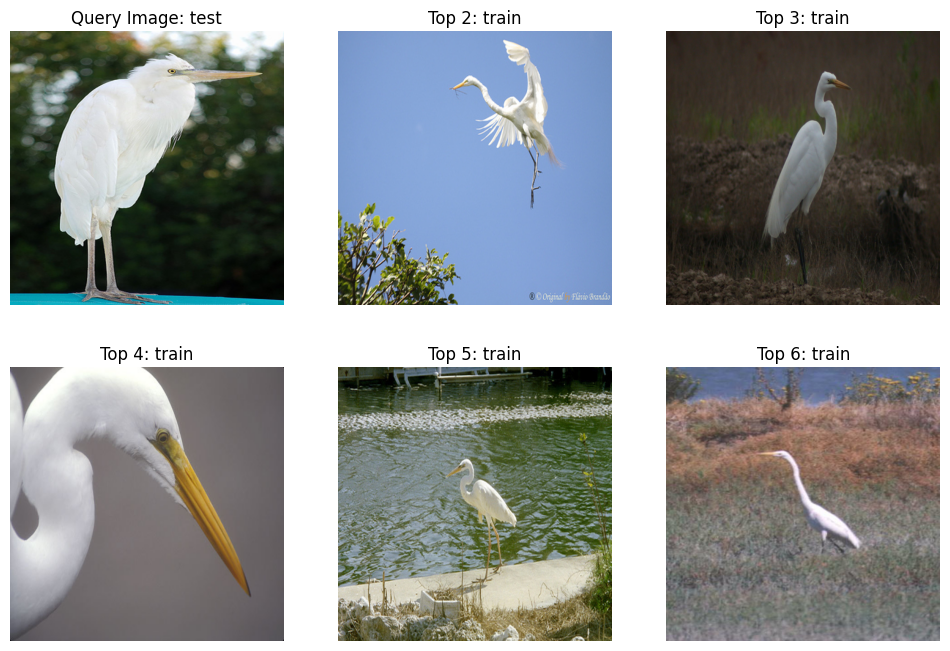

In [15]:
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

Search with Cosine Similarity

In [16]:
# Create a collection
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection",
                                                           metadata={HNSW_SPACE: "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

595it [00:34, 17.41it/s]


In [17]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)

In [18]:
cosine_results

{'ids': [['id_14', 'id_19', 'id_18', 'id_11', 'id_16']],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[None, None, None, None, None]],
 'distances': [[0.20247423648834229,
   0.20613527297973633,
   0.2540116310119629,
   0.2599222660064697,
   0.26471006870269775]]}

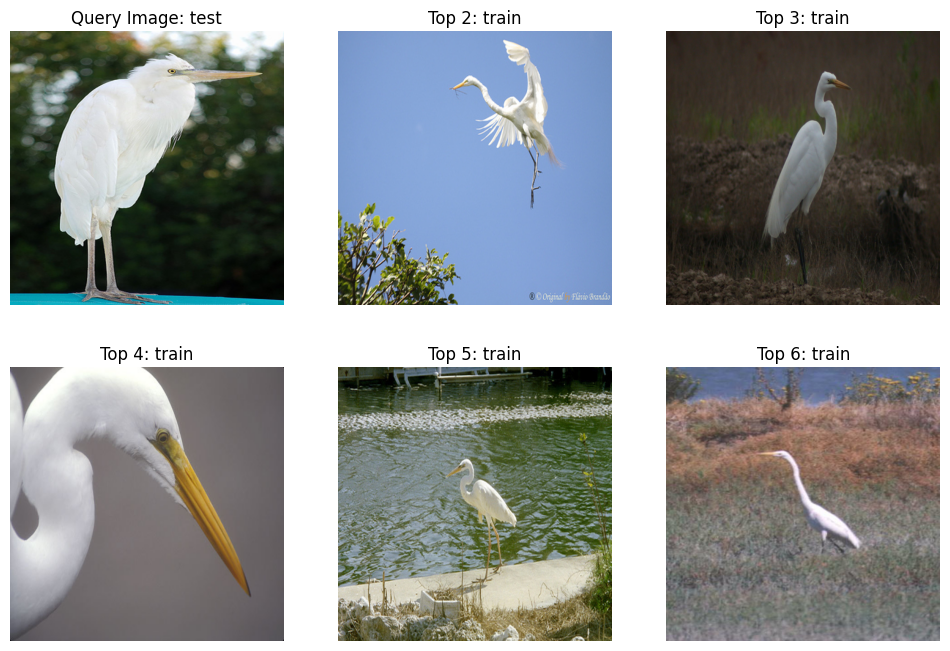

In [19]:
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)